# Data reading and preparation over ZIP code data 

In [75]:
from __future__ import print_function
# CFBP analysis 
import os
os.chdir('C:/Users/Rahil/Documents/Data incubator application/application_Oct_2018/CFBP')

path=os.getcwd()

import pandas as pd


filNames= os.listdir()
data= pd.read_csv(path+'/'+'Consumer_Complaints.csv')

In [76]:
# %%
index0=['Product', 'Sub-product', 'Issue', 'Sub-issue','Consumer complaint narrative', 'Company',
       'State', 'ZIP code', 'Submitted via','Complaint ID' ]
columns0=['count_unique', 'count_NANs']
CountSummaryTable=pd.DataFrame(index=index0, columns=columns0)

for i in index0:
    CountSummaryTable.loc[i]= [len(data[i].unique()), data[i].isnull().sum(axis=0)]

print('The table below shows total unique value and number of null/NAN/None (missing) values in each column')
CountSummaryTable

The table below shows total unique value and number of null/NAN/None (missing) values in each column


,count_unique,count_NANs
Product,18,0
Sub-product,77,235167
Issue,166,0
Sub-issue,219,513103
Consumer complaint narrative,319536,812487
Company,5055,0
State,64,15064
ZIP code,25684,88712
Submitted via,6,0
Complaint ID,1144848,0


In [77]:
data['ZIP code']


data2=data.copy()

data2['Clean_ZIPcode_5d']=data2['ZIP code'].str.extract('^(\d{5})$', expand=True)

data2['Clean_ZIPcode_5d'].isnull().sum(axis=0)
#Out[80]: 472589

len(data2['Clean_ZIPcode_5d'].dropna())
#Out[8]: 672259

data2['Clean_ZIPcode_5_3_d']=data2['ZIP code'].str.extract('^(\d{3,5}X{,2})$', expand=False)
#data2['Clean_ZIPcode_5_3_d'].isnull().sum(axis=0)
#Out[91]: 88798
len(data2['Clean_ZIPcode_5_3_d'].dropna())
pd.notnull(data2['Clean_ZIPcode_5_3_d']).sum(axis=0)
#Out[11]: 1056050

# if using the 3 digits zipcode with XX at the end as well as 5 digits, then use only       
data2['Clean_ZIPcode_5_3_d']=data2['Clean_ZIPcode_5_3_d'].str.slice(start=0, stop=3, step=None)
data2['Clean_ZIPcode_5_3_d'].dropna()
data2['ZipZone']=data2['Clean_ZIPcode_5_3_d'].str.slice(start=0, stop=1, step=None).astype('category')


### Pivot table for (Yaxis: product, issue, companies) and ZONE (on Xaxis), values are number of complaints
zoneList={'Clean_ZIPcode_5d':'Z5d', 'Clean_ZIPcode_5_3_d':'Z3d', 'ZipZone':'Z1d'}
#zoneName=['Z5d', 'Z3d', 'Z1d']
yaxisList= ['Product', 'Issue', 'Company']

pivotTables_basedZone={}
for z in zoneList:
    for y in yaxisList:
        PT= data2.pivot_table(values='Complaint ID',index= [y], columns= [z],
                           aggfunc=len, dropna=True)
        PT.fillna(0, inplace=True)
        pivotTables_basedZone[y+'_'+zoneList[z]]=PT #pd.to_numeric(PT, errors='raise', downcast='integer')
        print(y+'_'+zoneList[z])
        

Product_Z5d
Issue_Z5d
Company_Z5d
Product_Z3d
Issue_Z3d
Company_Z3d
Product_Z1d
Issue_Z1d
Company_Z1d


## Define function to plot and interact with widgets and parameters

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   
import seaborn as sns
sns.set(style="white")  
TopNList=np.arange(2,8,1)
zoneName='Z1d'
yaxisList= ['Product', 'Issue', 'Company']


In [87]:
def pieChart_ZoneBased_countComplains(source, numSlice):
    figs, axs= plt.subplots(nrows=5, ncols=2, squeeze=True, figsize=(14, 30)) #figsize=(25, 45)
    dataName=source +'_Z1d'
    TopN=numSlice
    for zoneI in range(10):
        PieData= pivotTables_basedZone[dataName][str(zoneI)].sort_values(ascending=False).iloc[0:TopN].values
        PieLabel= pivotTables_basedZone[dataName][str(zoneI)].sort_values(ascending=False).iloc[0:TopN].index[0:30]
        explode=np.zeros((TopN))
        explode[0]=0.1
        if zoneI<5:
            subLoc=[zoneI, 0]
        else:
            subLoc=[zoneI-5, 1]
        patches, texts, autotexts= axs[subLoc[0]][subLoc[1]].pie(PieData, explode=explode, labels=PieLabel, autopct='%1.1f%%',
                                      shadow=False, startangle=90)
        plt.setp(autotexts, size=14)
        autotexts[0].set_color('white')
        plt.setp(texts, size=12)
    #    plt.setp(patches, size='medium')
        axs[subLoc[0]][subLoc[1]].axis('equal')
        axs[subLoc[0]][subLoc[1]].set_title('Top %d %s for zone %d'%((TopN,dataName, zoneI)), fontweight="bold", size=16)

        
       


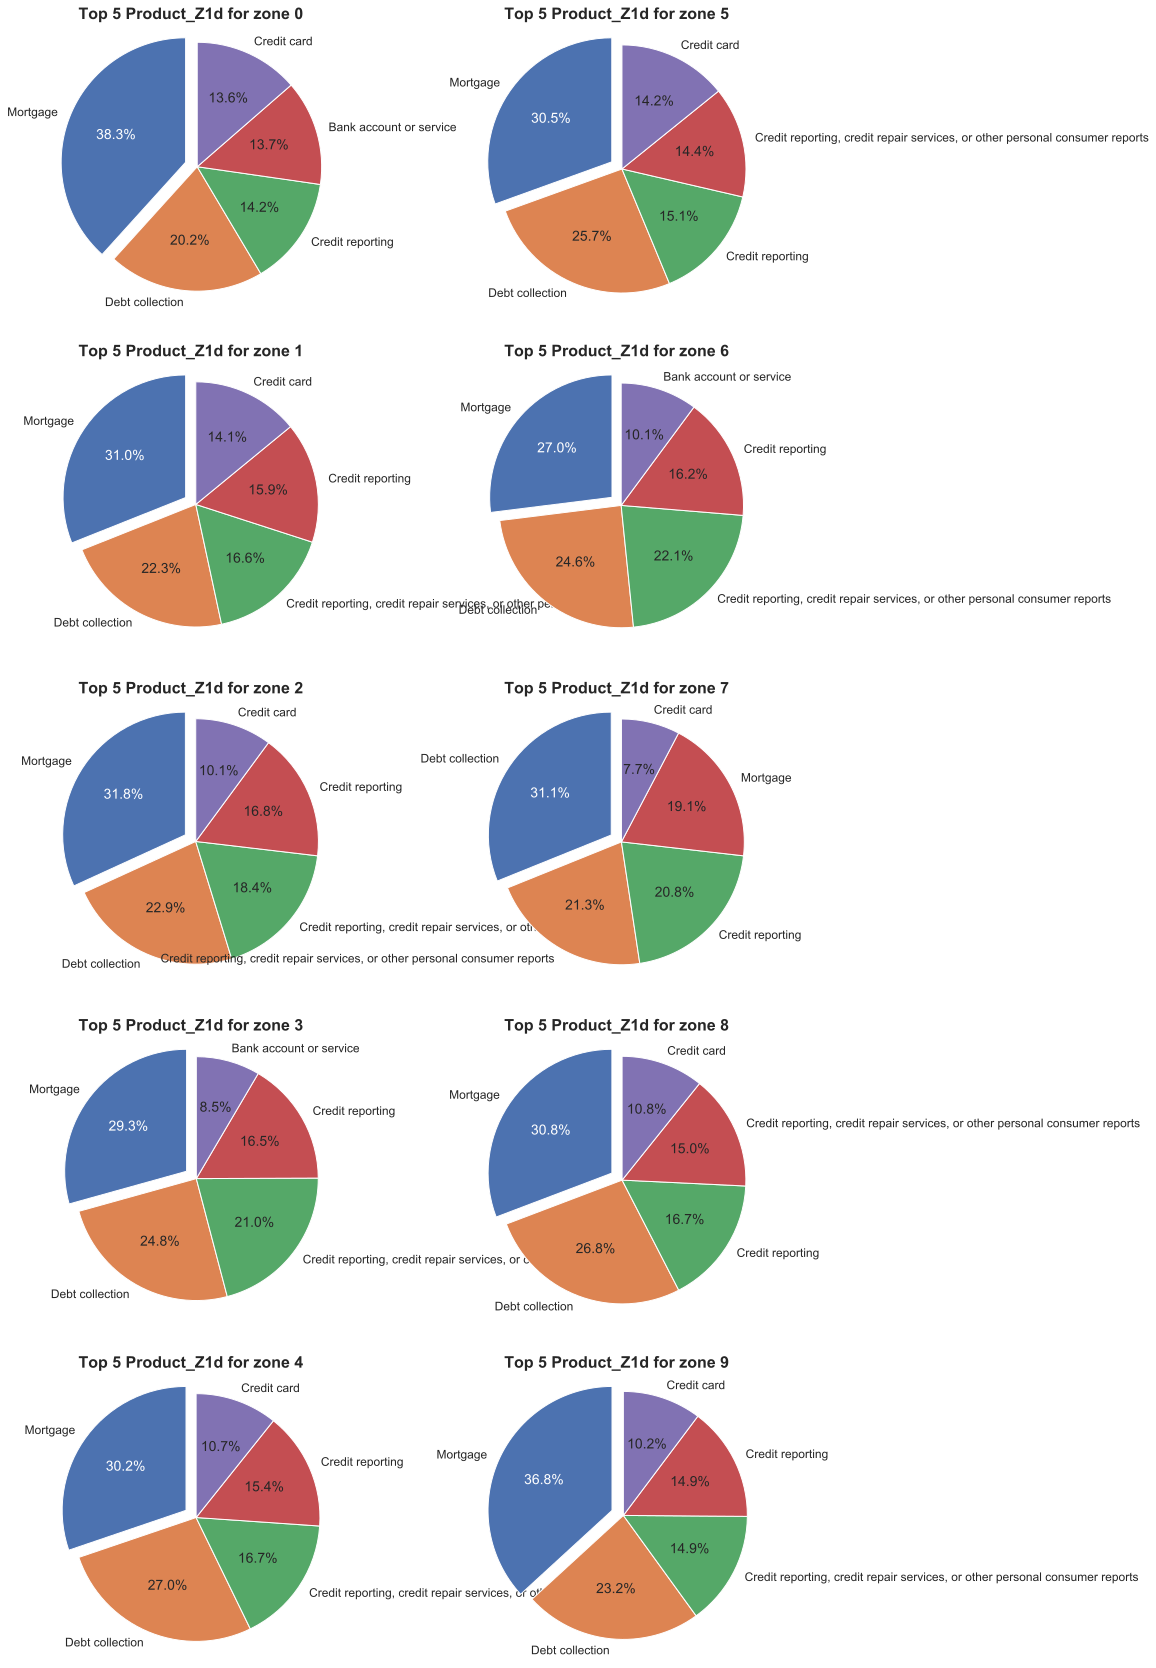

In [88]:
from ipywidgets import widgets
from IPython.display import display, clear_output, Image
from plotly.widgets import GraphWidget
from ipywidgets import interact, interactive, fixed, interact_manual


# --------- represent the interactive version with different source, and differernt number of slices------#
#interact(pieChart_ZoneBased_countComplains,source=yaxisList, numSlice= (2,5))
#%config InlineBackend.figure_format = 'svg'


# ---------- In order to show static plot on Git hub------#
%matplotlib inline
pieChart_ZoneBased_countComplains('Product', 5)


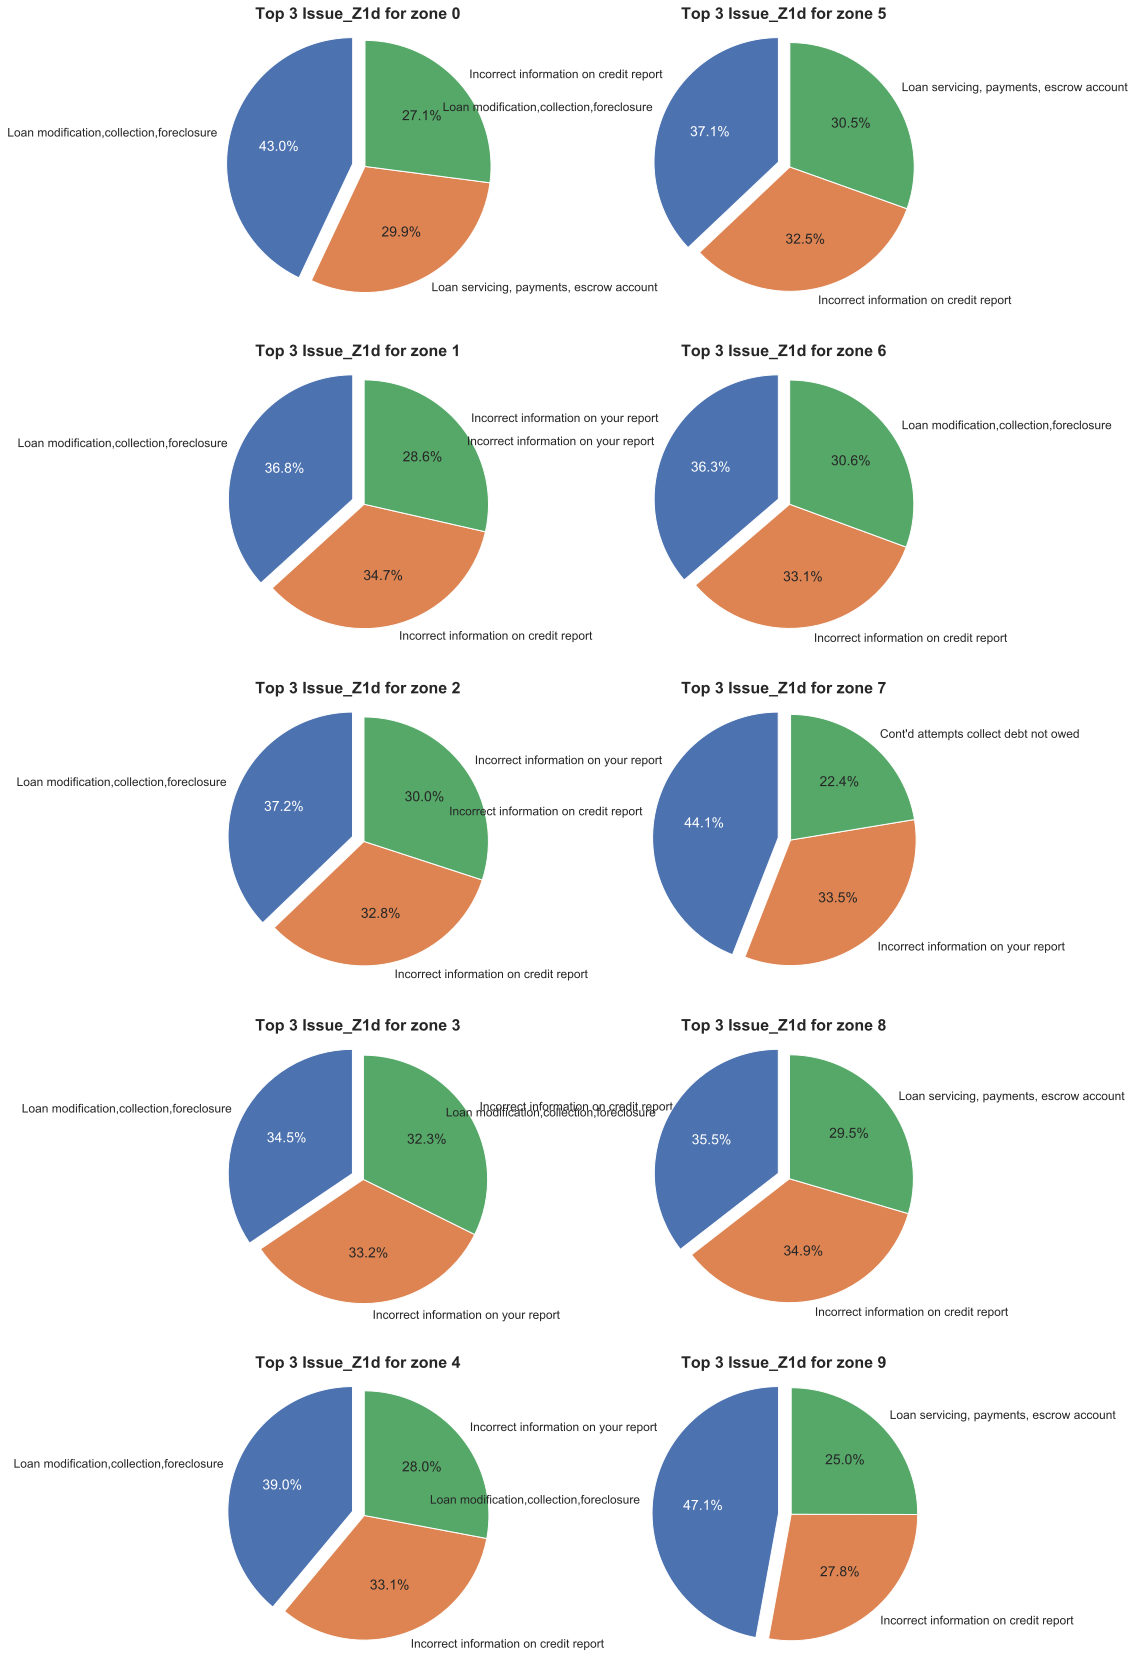

In [89]:
pieChart_ZoneBased_countComplains('Issue', 3)

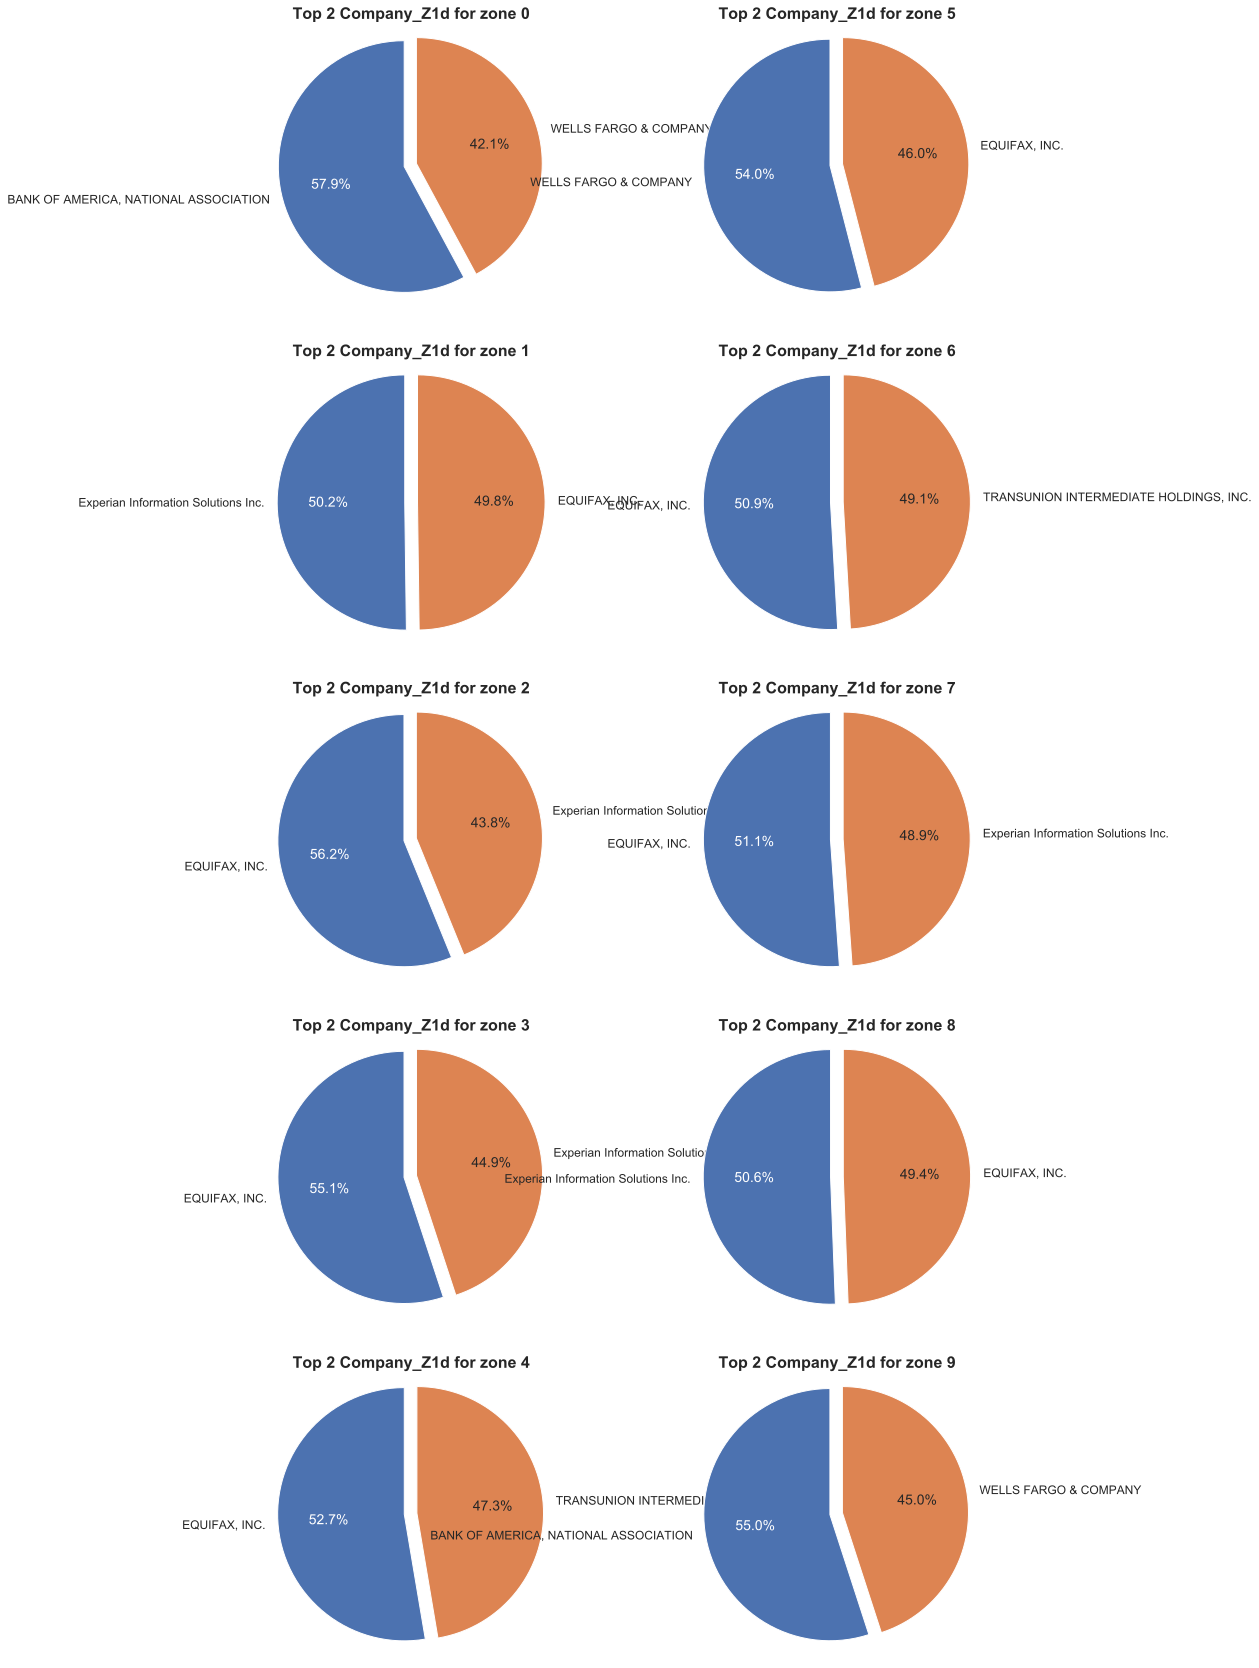

In [90]:
pieChart_ZoneBased_countComplains('Company', 2)

## Insights from observing the plots

This is the Pie chart to show the total number of complains per (product or issue or company), for each zone (first digit of a ZIP code) which starts from 0 in the east coast to 9 in the west coast. The reason for this plots is that I hypothesizes that complaint can reveal a pattern for each zone based on the property of the location. We can change the top number of results with the greatest number of complaints by changing the numSclice

If source is selected to be “Product” and number of slices on the Pie is 3 : 
The top 3 highest complains are from mortgage, debt and credit for all zones except Zone 7 which doesn’t have mortgage as top 3.

If source is selected to be “Issue” and number of slices on the Pie is 3 : 
The top 3 issue are loan modification, incorrect info on credit report, loan service and payment, except for Zone 7 which shows the third issue as continued attempt collect debt.

If the source is selected to be “company”, and number of slices on the Pie is 3 : 
Top 3 companies with the most complaints are bank of America, Equifax, wellsfargo, and in the second rank transunion,Experian information


With this data and with this visualization, it appears that ZIPcodes (zones) are not statistically different from each other in the matter of number of complains in products, issues and companies. 
